#  DSC670 Advanced Uses of Generative AI  #

## Project Milestone 3 - Fine tune Model  ##

### Saravanan Janarthanan ###

Steps for Finetuning the model to provide  responses from fine tuned domain information

**Step 1 Create a JSONL file with the below strucrure**

For this milestone the below JSONL structure is maitained
The JSONL (Chicken_receipe.jsonl) file contains a structured conversation-style dataset for fine-tuning an OpenAI model. Each line in the file is a JSON object with a "messages" key, which stores a list of role-based messages (system, user, assistant).

Sample format<br>

{<br>
  "messages": [<br>
    {"role": "system", "content": "You provide chicken recipes from a given list."},<br>
    {"role": "user", "content": "Give me a recipe for chicken Meatloaf"},<br>
    {"role": "assistant", "content": "Recipe Name: Chicken Meatloaf; Ingredients: ground chicken, onion, panko, Parmesan <br>cheese, ... Cooking Instructions: Preheat the oven to 350°F, mix ingredients, bake for 50 minutes."}<br>
  ]<br>
}<br>

System Role: Defines the assistant's behavior (e.g., "You provide chicken recipes from a given list.").<br>
User Role: Represents a user query (e.g., "Give me a recipe for chicken Meatloaf")Assistant Role: The AI's response, providing <br>the recipe (e.g., "Recipe Name: Chicken Meatloaf; Ingredients: ..., Cooking Instructions: ...").<br>



**Step 2 , Check the formats of JSONL file**

Check for Required Roles: while parsing check if list of allowed roles (e.g., "user", "assistant", "system").  validation script will check if the "role" field exists in each JSON object and if its value is in the allowed list.

Check Attributes: For each role, check if these attributes are present in the JSON object for the corresponding role.

This helps to avoid issues while fine tuning

**Step 3 check for token size in the JSONL**

Checking token size in a JSONL file requires a tokenizer that was used in based model so that the fine tuning process.

Model Specific Tokenization : Language models are trained with a particular tokenizer. The tokenizer is an integral part of how the model understands and processes text. Each tokenizer has its own vocabulary and rules for breaking down text into tokens. tiktoken is predominantly used for openai and the same is used here for encoding the JSONL

**Step 4 Load the JSONL file**

Fine-tuning an OpenAI model requires uploading a properly formatted JSONL (JSON Lines) file. While uploading the keyword purpose="fine-tune"  instructs openAI that file uploaded was indented for Fine tuning.  The uploaded file is just stored,  then the uploaded file is processed  and if valid it is marked as "processed".  At this stage the file is ready for fine -tuning.  If there are errors "failed" status will be marked. a file id is returned for reference.  

**Step 5 Kick Start the fine tuning job**

Using openAI api call the fine tuning process using the file id returned after JSONL was uploaded and define a base model to fine tune
For this project below base model is used
- gpt-4o-mini-2024-07-18

This process provides a job id for reference, Using job id the status of fine tuning can be fetched.

This process kick starts validation of training file and after validation it is queued for fine tuning. This indicates that the process is waiting for resources to be freed to start fine tuning
Once the fine tuning process starts the status changes from "queued"  to"running" .
Aftet the fine tuning is scuessfully completed the status changes to "succeeded"  and it provides a fine tuned model name or id.


**Step 6 Start using the fine tuned model for inference**

Once your fine-tuned model is trained and available, it can be used for inference, meaning it can generate responses based on the model’s knowledge.

The infered prompt or  message will use the JSNOL structure,  system role and user role with attributes as content. The user role content will include the prompt question and system role will instruct the model.

-----


In [45]:
# import the openai module to interact with base model and fine tuning process
import openai
# import json module to process json messages
import json
# Open AI specific module for encoding the tokens
import tiktoken

from openai import OpenAI
# api key is already stored in a text file in local directory

# Read the API key from the file
with open("apikey.txt", "r") as file:
    key = file.read().strip()  # Remove any extra whitespace or newlines

# Set the Key for accessing openAI
client = OpenAI(
    api_key=key,  
)

import os

# Set the OpenAI API key as an environment variable
os.environ["OPENAI_API_KEY"] = key


----

**Read the JSONL file to ensure that each line is a JSON object**

Read a JSONL file, parse each line as a JSON object, and store the objects in a list. It includes error handling to catch invalid JSON lines and provides informative error messages.

In [2]:
# Step 1: Validate the JSONL file, read the same and load each line as a list element
def validate_jsonl(jsonl_file):
    jsonl_data = []
    try:
        # open the JSONL file
        with open(jsonl_file, 'r') as file:
            for line_number, line in enumerate(file, start=1):   # Iterate the file to read each line
                #print(line)
                jsonl_data.append(json.loads(line.strip()))      # Check the json basic structure and load each line 
        print("JSONL file format is valid.")        
        return jsonl_data           
    except json.JSONDecodeError as e:
        raise ValueError(f"Error in line {line_number}: {e}")
    
    



----

**Validate JSONL format**

validates the format of JSONL data, specifically checking for required keys, valid values, and structural integrity. 
Perform a thorough validation of the structure and content of JSONL data used for fine-tuning, ensuring that it adheres to the expected format and contains the necessary information.<br>
- It iterate through each item in the messages list.  Each message is expected to be a dictionary.
- Check if both "role" and "content" keys are present in the current message dictionary.
- Check if the value associated with the "role" key is one of the allowed values: "system", "user", "assistant", or "function"
- Check if the content exists and is a string, or if a function_call exists.
- defaultdict is used for incrementing the errors if any, defaultdict creates an entry if it doesnot exisit and hence the check for exisiting error key is eliminated

In [3]:
from collections import defaultdict

# A method to validate the contents within the JSONL 
def check_jsonl_formats(jsondaata):
    # Format error checks - use a defaultdict to count occurrences  and 
    # that does not return error for missing keys.
    # For a requested key, the dictionary object initializes with a default value
    format_errors = defaultdict(int)
    
    # Iterate the JSONL message list
    for ex in jsondaata:
        # check if the filecontains a dictionary
        # messages contain dict elements
        if not isinstance(ex, dict):    
            format_errors["data_type"] += 1
            continue
        
        # parse the jsonl file ,  check if it contains the messages 
        messages = ex.get("messages", None)
        if not messages:
            format_errors["missing_messages_list"] += 1
            continue
        
        # Iertate each line under messages container
        for message in messages:
            # check if the line contains role and content key, value pair
            if "role" not in message or "content" not in message:
                format_errors["message_missing_key"] += 1
            # within each line,  if it contains more than one key value pair,  whether it has 
            # any of the key words "role", "content", "weight",  "fucntion_call"
            if any(k not in ("role", "content", "name", "function_call", "weight") for k in message):
                format_errors["message_unrecognized_key"] += 1
        
            # check if the values against role key has either of 
            # "system", "user", "assistant", "function"
            if message.get("role", None) not in ("system", "user", "assistant", "function"):
                format_errors["unrecognized_role"] += 1
            
            content = message.get("content", None)
            function_call = message.get("function_call", None)
        
            if (not content and not function_call) or not isinstance(content, str):
                format_errors["missing_content"] += 1
    
        if not any(message.get("role", None) == "assistant" for message in messages):
            format_errors["example_missing_assistant_message"] += 1

    if format_errors:
        print("Found errors:")
        for k, v in format_errors.items():
            print(f"{k}: {v}")
    else:
        print("No errors found")



----

**Estimate the Token count**

Calculate the total number of tokens in a set of messages, which is useful for estimating the token usage of your fine-tuning data and potentially reducing the size of your JSONL file if token limits are a concern.
Tokenizer for "gpt-4o-mini-2024-07-18" is set using the tiktoken module


In [4]:
# Count tokens that will aid if there is failure while fine tuning
# Reduce the JSONL file lines if high numner of tokens pose a issue
# Function to count tokens for a each line 
def count_tokens_in_message_set(message_set):
    token_count = 0
    for message in message_set["messages"]:
        # Concatenate role and content for tokenization
        role = message["role"]
        content = message["content"]
        token_count += len(tokenizer.encode(role)) + len(tokenizer.encode(content))
    return token_count

In [5]:
# method to count total tokens in JSONL file
def count_tokens_for_jsonl(jsonldata):   
    total_tokens = 0
    for idx, message_set in enumerate(jsonldata, start=1):
        message_tokens = count_tokens_in_message_set(message_set)
        total_tokens += message_tokens
        #print(f"Message Set {idx}: {message_tokens} tokens")

    # Display total token count
    print(f"Total Tokens: {total_tokens}")


-----

**Upload JSONL file to OpenAI**

Upload a training file  that was data validated, the file needs to be uploaded using the Files API in order to be used with a fine-tuning jobs. Upload a JSONL file to OpenAI for fine-tuning and it returns the ID of the uploaded file.

In [6]:
#  A method to upload the given json file to OpenAI
def upload_file_for_fineTuning(openAI_Client, jsonl_file):
    # Upload the JSONL file for fine-tuning
    fine_tune_file_det = openAI_Client.files.create(
        file=open(jsonl_file, "rb"),
        purpose="fine-tune"
    )
    # Return the  file id for reference during kick starting fine tuning job 
    return fine_tune_file_det.id



----

**Start the Finetuning process**

After ensuring the dataset's proper size, structure, and upload, the next step is to create a fine-tuning job.  The selected base model and uploaded file reference is used to start the job.  This helps the openAI to start traiing the model using uploaded file



In [24]:
# A method to start the fine tuning job using the uploaded file
def create_fine_tuning_job(openAI_Client, file_id, base_model):
    # kick start the fine tuning job
    fine_tune_job = openAI_Client.fine_tuning.jobs.create(
        training_file=file_id,    # uploaded file reference
        model=base_model,         # base model to be used for fine tuning
        hyperparameters={
        "n_epochs": 5,          # number of training epochs
        "batch_size": 1,         # training batch size
        "learning_rate_multiplier": 2,  # learning rate multiplier (scales the base rate)
    }

    )
    # return the job id for future refernece to check the status
    return fine_tune_job.id



----

**Monitor the fine tuning process**

Retrieve the status of a fine-tuning job on OpenAI and, if successful, retrieves and prints the ID of the fine-tuned model

After a fine-tuning job is started , it may take some time to complete. Job may be queued behind other jobs in system, and training a model can take minutes or hours depending on the model and dataset size. After the model training is completed,  an email confirmation is sent to the user account.  Mean shile this function can be used to check the intermediate stauses


In [8]:
# Monitor the fine-tuning status
# Monitor the fine-tuning job
# A method to check the status of the fine tuning
# as LLM queues the same and communciates in a mail when complete
# this method will provide the current status of fine tuning
# returns the fine tuned model name
def find_fine_tuning_status(openAI_Client, fine_tune_job_id):
    fine_tune_job_status = openAI_Client.fine_tuning.jobs.retrieve(fine_tune_job_id)
    status = fine_tune_job_status.status
    print("Fine tuning job status : ", status)
    if status == "succeeded":
            print(fine_tune_job_status.json())
            fine_tune_job_status_dict = json.loads(fine_tune_job_status.json())
            fine_tuned_model = fine_tune_job_status_dict["fine_tuned_model"]
            print(f"Fine-tuning completed successfully. Model ID: {fine_tuned_model}")
            return fine_tuned_model



----

**Orchestrate the fine tuning process**

Thsi orchestration is into three sections

- Section 1
    - Validate JSON structure
    - Run the JSONL file format,  structure validation process locally to resolve any issues before uploading the file
    - count the token to ensure it is within the limit and take necessary action based on count
    
- Section 2
    - Upload the JSONL file into OpenAI system
    - Start the fine tuning process
    
- Section 3
    - Monitor the fine tuning process status







-----

**Orchestration Section 1**

This section step ensures that your JSONL file adheres to OpenAI's required format. Even small deviations can cause upload failures or incorrect fine-tuning.

OpenAI's fine-tuning pricing is often based on token usage. It's crucial to estimate the number of tokens in your training data before you start fine-tuning to:
- Predict costs.
- Ensure you are within any token limits.
- Identify long examples that might be problematic.

In [16]:
# Orchestrate Validation,  checking formats, count tokens 
import tiktoken

#input_jsonl_file = "Chicken_receipe.jsonl"

input_jsonl_file = "Reformatted_Chicken_Recipes_v2.jsonl"

# Choose the model to finetune
MODEL_NAME = "gpt-4o-mini-2024-07-18"

# check if the JSON strcuture (readable as a JSON)
jsonl_data = validate_jsonl(input_jsonl_file)

# check if the JSONL file meets the expected training struture
check_jsonl_formats(jsonl_data)

# Use tiketoken specific to chosen model
tokenizer = tiktoken.encoding_for_model(MODEL_NAME)

# Count the tokens
count_tokens_for_jsonl(jsonl_data)





JSONL file format is valid.
No errors found
Total Tokens: 14139




-----

**Orchestration Section 2**

Upload the JSON file into OpenAI system and ensure it is processed.  It returns a file id to be used for starting fine tuning process.

After sucessful validation start the fine tuning process. It returns a job id for future reference.


In [49]:
# Upload the file
ft_file_id = upload_file_for_fineTuning(client, input_jsonl_file)
print("The Uploaded File id: ", ft_file_id)

The Uploaded File id:  file-AdVS7sTwKUkes9N17maRwq


In [50]:
# start the fine tuning process
ft_job_id = create_fine_tuning_job(client, ft_file_id, MODEL_NAME)
print("The fine tuning request sent and the job is is ", ft_job_id)

The fine tuning request sent and the job is is  ftjob-zzYSo4EWaaZZv0mOT6xDAcbj


-----

**Orchestration Section 3**

Keep monitoring the status and if the status is "succeeded" then the model id is returned for using it for inference



----

**Inference or putting to use the fine tuned model**

In [31]:
def infer_fine_tuned_model(model_id, user_content):
    completion = client.chat.completions.create(
        model=model_id,
        messages=[
            {"role": "system", "content": "You being a great chef provide chicken recipes from the finetuned model only"},
            {"role": "user", "content": user_content}
        ],
        temperature=0.3
    )

    print(completion.choices[0].message)

In [27]:
find_fine_tuning_status(client, ft_job_id)

Fine tuning job status :  succeeded
{"id":"ftjob-W3DosWmIHYqj7mE0unkjwxXC","created_at":1740803968,"error":{"code":null,"message":null,"param":null},"fine_tuned_model":"ft:gpt-4o-mini-2024-07-18:personal::B692dQjK","finished_at":1740804422,"hyperparameters":{"batch_size":1,"learning_rate_multiplier":2.0,"n_epochs":5},"model":"gpt-4o-mini-2024-07-18","object":"fine_tuning.job","organization_id":"org-szNTzYMcCViBQFvI8yYmapNm","result_files":["file-VY3HbKPmLPKKPWyiKkq9TK"],"seed":1913158387,"status":"succeeded","trained_tokens":72980,"training_file":"file-6fD8xHiusTVinrAa8XaWza","validation_file":null,"estimated_finish":null,"integrations":[],"method":{"dpo":null,"supervised":{"hyperparameters":{"batch_size":1,"learning_rate_multiplier":2.0,"n_epochs":5}},"type":"supervised"},"user_provided_suffix":null}
Fine-tuning completed successfully. Model ID: ft:gpt-4o-mini-2024-07-18:personal::B692dQjK


C:\Users\poorn\AppData\Local\Temp\ipykernel_17312\2117883182.py:12: PydanticDeprecatedSince20: The `json` method is deprecated; use `model_dump_json` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  print(fine_tune_job_status.json())
C:\Users\poorn\AppData\Local\Temp\ipykernel_17312\2117883182.py:13: PydanticDeprecatedSince20: The `json` method is deprecated; use `model_dump_json` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  fine_tune_job_status_dict = json.loads(fine_tune_job_status.json())


'ft:gpt-4o-mini-2024-07-18:personal::B692dQjK'

In [ ]:
find_fine_tuning_status(client, ft_job_id)

In [28]:
model_id = find_fine_tuning_status(client, ft_job_id)
print(model_id)

Fine tuning job status :  succeeded
{"id":"ftjob-W3DosWmIHYqj7mE0unkjwxXC","created_at":1740803968,"error":{"code":null,"message":null,"param":null},"fine_tuned_model":"ft:gpt-4o-mini-2024-07-18:personal::B692dQjK","finished_at":1740804422,"hyperparameters":{"batch_size":1,"learning_rate_multiplier":2.0,"n_epochs":5},"model":"gpt-4o-mini-2024-07-18","object":"fine_tuning.job","organization_id":"org-szNTzYMcCViBQFvI8yYmapNm","result_files":["file-VY3HbKPmLPKKPWyiKkq9TK"],"seed":1913158387,"status":"succeeded","trained_tokens":72980,"training_file":"file-6fD8xHiusTVinrAa8XaWza","validation_file":null,"estimated_finish":null,"integrations":[],"method":{"dpo":null,"supervised":{"hyperparameters":{"batch_size":1,"learning_rate_multiplier":2.0,"n_epochs":5}},"type":"supervised"},"user_provided_suffix":null}
Fine-tuning completed successfully. Model ID: ft:gpt-4o-mini-2024-07-18:personal::B692dQjK
ft:gpt-4o-mini-2024-07-18:personal::B692dQjK


C:\Users\poorn\AppData\Local\Temp\ipykernel_17312\2117883182.py:12: PydanticDeprecatedSince20: The `json` method is deprecated; use `model_dump_json` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  print(fine_tune_job_status.json())
C:\Users\poorn\AppData\Local\Temp\ipykernel_17312\2117883182.py:13: PydanticDeprecatedSince20: The `json` method is deprecated; use `model_dump_json` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  fine_tune_job_status_dict = json.loads(fine_tune_job_status.json())


In [40]:
# set the model id recieved
FT_MODEL_NM = model_id

In [46]:
infer_fine_tuned_model(FT_MODEL_NM, "Get me a recipe for Chicken Curry")

ChatCompletionMessage(content='Recipe Name:\n Chicken Curry\n\nIngredients:\n-  Chicken Curry 1 kg Chicken (bone-in) 1 large Lemon 2 tbsp Kashmiri Chilli Powder 1 tbsp Turmeric Powder 2 tbsp Salt 3 tbsp Ginger Garlic Paste 4 tbsp Oil 2 large Onions sliced thinly 2 large Green Chilli slit 2 tbsp Ginger chopped finely 2 tbsp Garlic chopped finely 1 sprig Curry Leaves 1 cup Water 2 tsp Garam Masala Powder 1 tbsp Coriander Leaves finely chopped For Roasting & Grinding 3 tbsp Oil 2 tbsp Coriander Seeds 2 tbsp Fennel Seeds 1 tbsp Cumin Seeds 1 tbsp Black Pepper 5 no Dry Red Chilli 1 piece Cinnamon 1 piece Stone Flower 1 cup Freshly Grated Coconut\n\nCooking Instructions:\n1.  Take chicken in a bowl\n2. Add in lemon juice, salt, chilli powder, turmeric powder and ginger garlic paste\n3. Mix well and set aside for 10 mins\n4. Heat 3 tblsp oil in a pan, add chicken and sear on high heat for 5 mins\n5. Remove to a bowl\n6. In the same pan, add 2 tblsp oil, add onions, green chillies, curry leave

In [47]:
infer_fine_tuned_model(FT_MODEL_NM, "what is the recipe for dhaba chicken gravy recipe")

ChatCompletionMessage(content='Recipe Name: Dhaba Style Chicken Gravy; Ingredients : For Chicken Gravy Recipe - 1 kg Chicken 2 Onions 2 large Tomatoes 2 tbsp Kashmiri Chilli Powder 1 tbsp Turmeric Powder 1 tbsp Garam Masala Powder 3 tbsp Ginger Garlic Paste 3 tbsp Lemon Juice Salt to taste For Cooking Chicken - 3 tbsp Oil 1 tbsp Ghee 2 tsp Cumin Seeds 2 Cinnamon Stick 2 large Bay Leaf 6 Green Cardamom 6 Black Pepper 1 cup Water 1 cup Curd (Yogurt) For Onion Paste - 2 tbsp Oil 2 large Onions sliced 2 Green Chillies slit 1 tbsp Ginger Garlic Paste 1 tbsp Lemon Juice Salt to taste For Tomato Paste - 1 tbsp Oil 2 large Tomatoes chopped 1 tbsp Ginger Garlic Paste 1 tbsp Lemon Juice Salt to taste 2 tbsp Coriander Leaves; Cooking Instructions : Take curd in a bowl, add in 1 tsp salt and whisk till smooth. Set aside. Heat 3 tblsp oil in a pot. Add in cumin and other whole spices. Add in chicken and sear on high heat for 5 to 6 minutes. Add in salt, ginger garlic paste and mix well. Add in lemo

In [48]:
infer_fine_tuned_model(FT_MODEL_NM, "how to cook Clear butter chicken meatzball")

ChatCompletionMessage(content='Recipe Name: Clear Butter Chicken Meatzball; Ingredients : For Chicken Stock - 2 tbsp Butter 1 large Onion chopped finely 1 tbsp Ginger Garlic Paste 2 Green Chillies slit 1 large Tomato chopped 1 tbsp Chicken Stock Powder 4 cups Water 500 grams Chicken Boneless For Chicken Meatballs - 500 grams Chicken Boneless 2 tbsp Butter 1 large Onion chopped finely 1 tbsp Ginger Garlic Paste 2 Green Chillies slit 1 large Tomato chopped 1 tbsp Chicken Stock Powder 4 tbsp Bread Crumbs 1 tbsp Chicken Stock Powder 1 tsp Salt 1 tsp Kashmiri Chilli Powder 1 tsp Garam Masala Powder 1 tbsp Coriander Leaves finely chopped 2 tbsp Cashews finely chopped 2 tbsp Butter For Butter Chicken Sauce - 2 tbsp Butter 1 large Onion chopped finely 1 tbsp Ginger Garlic Paste 2 Green Chillies slit 1 large Tomato chopped 1 tbsp Chicken Stock Powder 4 cups Water 1 tsp Salt 1 tsp Kashmiri Chilli Powder 1 tsp Garam Masala Powder 2 tbsp Cashews finely chopped 2 tbsp Coriander Leaves finely choppe



----

**Conclusion**



Metrics



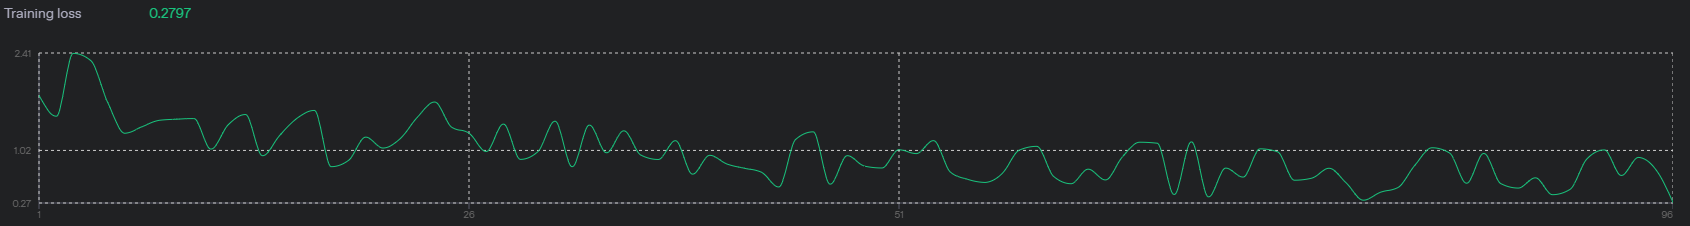

- Training loss : 0.27
    - The final training loss indicates how well the model has minimized errors during training. A lower loss generally means better performance, but loss alone is not a perfect indicator of fine-tuning success.
    - Loss below 0.5 is generally good, but since the model did not generate expected responses, this suggests it may not have learned the desired patterns effectively.
- batch size of 1 is used
    - A batch size of 1 means the model processed one training sample at a time during each update.
    - Multiple runs required to increae it if needed
- learning rate multiplier of 1.8 was used  (can range betweeen 0.0001 to 10)  
    - This learning rate is very high
- Number of epochs : 4 is used
- Trained tokens 34,564

The Fine tuned model using custom JSONL recipe did not pick the response from the trained data from the above 3 samples.

Possible reason :  
- The training data is insufficient, Need to add more training data,  Will be tried 
- May try to use a different system prompts as the same prompt is used -  less likely to influence the results hence not tried


